# Welcome to the ROOT-LBN Tutorial

* Created: 16/06/2020
* Contact: dennis . noll [at] cern . ch

This notbook showcases, how a simple classification between two physics processes can be implemented using the Lorentz Boost Network ([LBN](https://arxiv.org/abs/1812.09722)).
We will start with two **root files** and end with a fully trained classifier which can be applied on **numpy arrays**.

For input data we use NANOAOD simulations following `RunIIFall17NanoAODv6`.
The two root files contain physics events from two different processes with the same final state:
* `signal.root`: GluGluToHHTo2B2WToLNu2J_node_SM
* `background.root`: TTToSemiLeptonic

All the needed software is pinned in the `environment.yml` file.
It can be installed and sourced using [`conda`](https://docs.conda.io/en/latest/).

In [1]:
import itertools

import numpy as np
import tensorflow as tf
import uproot
import uproot_methods
import awkward
from lbn import LBN, LBNLayer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

TLorentzVectorArray = uproot_methods.classes.TLorentzVector.TLorentzVectorArray

Check for correct tensorflow version and GPU availability:

In [2]:
assert tf.__version__.startswith("2")
print("Available GPU:", tf.config.list_physical_devices('GPU'))

Available GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Data

Define some functions that handle uproot data formats and convert `TLorentzVectors` consisting of the transverse momentum, the pseudorapidity, the phi angle and the mass to four vectors consisting of the energy and the three momentum.

In [3]:
def tree_to_lorentz(tree, name="Jet"):
    return TLorentzVectorArray.from_ptetaphim(
        tree["%s_pt" % name].array(),
        tree["%s_eta" % name].array(),
        tree["%s_phi" % name].array(),
        tree["%s_mass" % name].array()
    )


def tree_to_array(tree, mask, name="Jet", n=4):
    lorentz = tree_to_lorentz(tree, name=name)
    array = np.array([
        lorentz[mask].E[:, :n],
        lorentz[mask].x[:, :n],
        lorentz[mask].y[:, :n],
        lorentz[mask].z[:, :n],
    ])
    return np.moveaxis(array, 0, 2)

Load data for signal and background:

In [4]:
DATA_PATH = "/eos/user/d/dnoll/HH/lbn/%s.root"
DATA_PATH = "/net/scratch/dn801636/projects/root_to_lbn/data/%s.root"
signal, background = uproot.open(DATA_PATH % "signal"), uproot.open(DATA_PATH % "background")
signal_tree, background_tree = signal["Events"], background["Events"]

In this simple example we will select events with exactly one electron with transverse momentum greater than 25 GeV and equal or more than four jets:

In [5]:
def event_selection(tree):
    e_mask = tree["nElectron"].array() == 1
    pt_mask = (tree["Electron_pt"].array() > 25).any()
    jet_mask = tree["nJet"].array() >=4
    return e_mask * pt_mask * jet_mask

Create a boolean mask for the event selection:

In [6]:
signal_mask, background_mask = event_selection(signal_tree), event_selection(background_tree)

Specification of low and high level input data. As low level inputs, we will use the four momenta of the four jets with the highest momentum, and the electron, as high level feature we will use the variable "MET_pt" which is defined on the event level:

In [7]:
def get_low_level(tree, mask):
    jets = tree_to_array(tree, mask, name="Jet")
    electron = tree_to_array(tree, mask, name="Electron", n=1)
    events = np.concatenate([jets, electron], axis=1)
    return events

def get_high_level(tree, mask, variables=["MET_pt"]):
    output = np.array([tree[variable].array()[mask] for variable in variables])
    return np.moveaxis(output, 0, 1)

Get low and high level data, which will be used for the LBN and the following DNN respectively:

In [8]:
signal_ll, signal_hl = get_low_level(signal_tree, signal_mask), get_high_level(signal_tree, signal_mask)
background_ll, background_hl = get_low_level(background_tree, background_mask), get_high_level(background_tree, background_mask)

Encode targets to one_hot vectors:

In [9]:
signal_targets = tf.keras.backend.one_hot(np.ones(signal_ll.shape[0]), 2)
background_targets = tf.keras.backend.one_hot(np.zeros(background_ll.shape[0]), 2)

We have a factor ~10 more background than signal events and have to explicitly care that the network does not only concentrate on the background class.
One option is to use a class weight on each event in the loss function, giving a small weight to the background and a large weight to the signal.
This approach works fine if the size differences between the classes are not too large.
We will use it in this example. Because the differences are already pretty large (factor ~10), our validation accuracy will fluctuate.
If the differences are to large, we have to crop the larger class or, as an even better approach, sample up the smaller class.

In [10]:
# n_signal = signal_ll.shape[0]
# background_ll, background_hl, background_targets = background_ll[:n_signal], background_hl[:n_signal], background_targets[:n_signal]

Concatenate and shuffle signal and background samples:

In [11]:
def shuffle_together(*arrays):
    first_array = arrays[0]
    assert [len(first_array) == len(array) for array in arrays[1:]]
    p = np.random.permutation(len(first_array))
    return [array[p] for array in arrays]

In [12]:
ll = np.concatenate([signal_ll, background_ll], axis=0).astype(np.float32)
hl = np.concatenate([signal_hl, background_hl], axis=0).astype(np.float32)
targets = np.concatenate([signal_targets, background_targets], axis=0)

ll, hl, targets = shuffle_together(ll, hl, targets)

Normalize high-level features:

In [13]:
hl_mean, hl_std = np.mean(hl, axis=0), np.std(hl, axis=0)
hl = (hl - hl_mean) / hl_std

Validate the shapes:

In [14]:
print("Shape LL", ll.shape)
print("Shape HL", hl.shape)
print("Shape targets", targets.shape)

Shape LL (146209, 5, 4)
Shape HL (146209, 1)
Shape targets (146209, 2)


Split the data, use 90% for training and 10% for validation:

In [15]:
n_data = ll.shape[0]
split = int(n_data * 0.9)
print("Splitting data into", split, "training and", n_data-split, "validation events")

ll_train, hl_train, ll_val, hl_val = ll[:split], hl[:split], ll[split:], hl[split:]
y_train, y_val = targets[:split], targets[split:]

Splitting data into 131588 training and 14621 validation events


Calculate the class weights which we will later use in the fit procedure:

In [16]:
i_targets = np.argmax(targets, axis=1)
class_weight = compute_class_weight('balanced', classes=np.unique(i_targets), y=i_targets)
class_weight = dict(enumerate(class_weight))
print("Class weight:", class_weight)

Class weight: {0: 0.5550371647015055, 1: 5.042385156573321}


## Build the model
Now we set up the model with `tf.keras`.
First some general network parameters:

In [17]:
n_classes = 2
n_nodes = 256
activation = "relu"
dropout = 0.1

We use the functional API, where we can feed two inputs:

In [18]:
ll_inputs = tf.keras.Input(shape=(5, 4), name="LL")
hl_inputs = tf.keras.Input(shape=(1,), name="HL")

Initialize the Lorentz Boost Network and use it as first layer of the network:

In [19]:
lbn_layer = LBNLayer(ll_inputs.shape, 10, boost_mode=LBN.PAIRS, features=["E", "pt", "eta", "phi", "m", "pair_cos"])
lbn_features = lbn_layer(ll_inputs)

Normalize the features from the LBN (energy, transverse momentum, ...) with a BatchNormalization:

In [20]:
normalized_lbn_features = tf.keras.layers.BatchNormalization()(lbn_features)

Concatenate the normalized features from the LBN and the high level features:

In [21]:
x = tf.keras.layers.concatenate([normalized_lbn_features, hl_inputs])

Add the feed forward network constisting of some dense layers with dropout between the layers:

In [22]:
x = tf.keras.layers.Dense(n_nodes, activation=activation)(x)
x = tf.keras.layers.Dropout(dropout)(x)
x = tf.keras.layers.Dense(n_nodes, activation=activation)(x)
x = tf.keras.layers.Dropout(dropout)(x)
outputs = tf.keras.layers.Dense(n_classes)(x)

Create and compile the model:

In [23]:
model = tf.keras.Model(inputs=[ll_inputs, hl_inputs], outputs=outputs, name='lbn_dnn')
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

Get a summary of the created model with the number of total trainable variables:

In [24]:
model.summary()

Model: "lbn_dnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
LL (InputLayer)                 [(None, 5, 4)]       0                                            
__________________________________________________________________________________________________
LBN (LBNLayer)                  (None, 95)           100         LL[0][0]                         
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 95)           380         LBN[0][0]                        
__________________________________________________________________________________________________
HL (InputLayer)                 [(None, 1)]          0                                            
____________________________________________________________________________________________

## Train the model
At last, fit the model to the data:

In [25]:
model.fit(
    [ll_train, hl_train],
    y_train,
    epochs=5,
    batch_size=1024,
    class_weight=class_weight,
    validation_data=([ll_val, hl_val], y_val),
)

Epoch 1/5
129/129 [==============================] - 3s 20ms/step - loss: 0.6656 - accuracy: 0.6285 - val_loss: 0.7143 - val_accuracy: 0.5656
Epoch 2/5
129/129 [==============================] - 2s 17ms/step - loss: 0.6374 - accuracy: 0.6644 - val_loss: 0.6443 - val_accuracy: 0.6504
Epoch 3/5
129/129 [==============================] - 2s 17ms/step - loss: 0.6287 - accuracy: 0.6675 - val_loss: 0.6154 - val_accuracy: 0.6869
Epoch 4/5
129/129 [==============================] - 2s 17ms/step - loss: 0.6235 - accuracy: 0.6669 - val_loss: 0.6033 - val_accuracy: 0.6976
Epoch 5/5
129/129 [==============================] - 2s 17ms/step - loss: 0.6191 - accuracy: 0.6752 - val_loss: 0.6163 - val_accuracy: 0.6816


And plot a simple confusion matrix for the final classificaiton:

In [28]:
def plot_confusion_matrix(cm, class_names):
    figure = plt.figure(figsize=(4, 4))
    plt.imshow(cm, interpolation='nearest', cmap="summer")
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(i, j, cm[i, j], horizontalalignment="center", size=18)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig("hh_tt.pdf")
    plt.show()

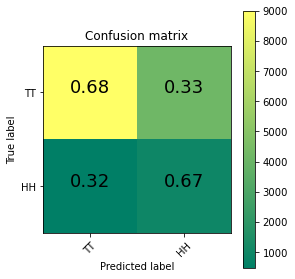

In [29]:
pred_val = model.predict([ll_val, hl_val], batch_size=1024)
cm = confusion_matrix(np.argmax(y_val, axis=1), np.argmax(pred_val, axis=1))
plot_confusion_matrix(cm, ["TT", "HH"])